In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob

In [4]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_MPI-ESM1-2-LR_historical_*.nc'
# #data_hist_CanESM5 = '/pool/data/CMIP6/data/CMIP/CCCma/CanESM5/historical/tas_*.nc'
# #data_hist_GFDL    = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# #data_ssp370 = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp370/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# #data_ssp585 = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# import glob
# myfiles = glob.glob(data_hist_MPI_ESM)
# file_list = sorted(myfiles)
# file_list

In [5]:
# for i in range(len(file_list)):
#     ds = xr.open_dataset(file_list[i])
#     ds = ds.assign_coords({'run': i+1})
#     ds.to_netcdf('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_MPI-ESM1-1-LR_run'+str(i+1)+'_185001-201412_rg.nc')

In [6]:
# ds = xr.open_mfdataset('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_*.nc',combine='None')
ds = xr.open_mfdataset('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_MPI*.nc', combine = 'nested', concat_dim = 'run')
ds
# ds['tas'].to_netcdf('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_1850-2014_30run.nc')
# tas = ds['tas'].loc['1850-01-01':'2014-12-01',0:90,:]
# tas.shape

<xarray.Dataset>
Dimensions:    (time: 1980, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 1980, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [7]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [8]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

# # Broadcast the mask to match the shape of the original dataset's time dimension
# broadcasted_mask = xr.broadcast(mask_data, ds['time'])[0]

# # Apply the land-sea mask to the original dataset
# masked_tas = xr.where(broadcasted_mask == 1, ds, np.nan).fillna(np.nan)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 1980, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 1980, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [10]:
tas = masked_tas['tas'].loc[:,'1900-01-01':'2014-12-01',:,:]
tas = tas - 273.15
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano
lat = tas_ano['lat']
lon = tas_ano['lon']

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 115 times more chunks
  return self.array[key]


In [11]:
#Separate data into monthly and output as new nc file
time_data = tas_ano['time']
time_index = pd.to_datetime(time_data.values)
time_index

DatetimeIndex(['1900-01-16 12:00:00', '1900-02-15 00:00:00',
               '1900-03-16 12:00:00', '1900-04-16 00:00:00',
               '1900-05-16 12:00:00', '1900-06-16 00:00:00',
               '1900-07-16 12:00:00', '1900-08-16 12:00:00',
               '1900-09-16 00:00:00', '1900-10-16 12:00:00',
               ...
               '2014-02-15 00:00:00', '2014-03-16 12:00:00',
               '2014-04-16 00:00:00', '2014-05-16 12:00:00',
               '2014-06-16 00:00:00', '2014-07-16 12:00:00',
               '2014-08-16 12:00:00', '2014-09-16 00:00:00',
               '2014-10-16 12:00:00', '2014-11-16 00:00:00'],
              dtype='datetime64[ns]', length=1379, freq=None)

In [12]:
# for month in time_index.month.unique():
#     month_data = tas_ano.sel(time=time_index.month==month)
#     output_file_path= f"/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_{month}.nc"
#     month_data.to_netcdf(output_file_path)

In [13]:
weights = np.cos(np.deg2rad(tas.lat))*xr.ones_like(tas['lon'])

In [14]:
#calculate the annual mean of the SAT
# weights = np.cos(np.deg2rad(tas_ano.lat))
# weights.name = "weights"
# weights

tas_ano_weighted = tas_ano.weighted(weights)
# display(tas_ano_weighted)
tas_ano_weighted_mean = tas_ano_weighted.mean(dim=['lat','lon'])
tas_ano_weighted_mean

<xarray.DataArray 'tas' (run: 30, time: 1379)>
dask.array<truediv, shape=(30, 1379), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 1900-02-15 ... 2014-11-16
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 1 2 3 4 5 6 7 8 9 10 11

In [15]:
tas_ano_annual = tas_ano_weighted_mean.groupby('time.year').mean('time')
tas_ano_annual
# display(tas_ano_annual.min().values)
# tas_ano_annual.max().values

<xarray.DataArray 'tas' (run: 30, year: 115)>
dask.array<transpose, shape=(30, 115), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2010 2011 2012 2013 2014

In [16]:
seasons = ['JJA', 'DJF']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    
    season_months = tas_ano.sel(time=tas.time.dt.month.isin(months),lat=slice(0,90))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = (season_months * weights).mean(dim=['lat', 'lon']) / weights.mean(dim=['lat', 'lon'])
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies

# Access the multiyear JJA mean SAT anomalies
    
JJA_tas = season_means['JJA']
DJF_tas = season_means['DJF']

JJA_tas

<xarray.DataArray (run: 30, time: 345)>
dask.array<truediv, shape=(30, 345), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-06-16 ... 2014-08-16T12:00:00
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 6 ... 6 7 8 6 7 8 6 7 8 6 7 8

In [17]:
DJF_tas_mean = DJF_tas.groupby('time.year').mean(dim='time')
DJF_tas_mean

<xarray.DataArray (run: 30, year: 115)>
dask.array<transpose, shape=(30, 115), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2010 2011 2012 2013 2014

In [18]:
JJA_tas_mean = JJA_tas.groupby('time.year').mean(dim='time')
JJA_tas_mean[0,:].values

array([-0.54057811, -0.4629675 , -0.32102401, -1.29619368, -0.62728439,
       -0.14692027, -0.74930397, -0.58631608, -0.30202501, -0.79762971,
       -0.38723258, -0.04511298, -0.66302857, -0.59899291, -0.32896928,
       -0.20963342, -0.46062472, -0.49962735, -0.54284767, -0.401551  ,
       -0.17647469, -0.17321905, -0.25453552, -0.19177317, -0.08622386,
       -0.42822004, -0.47601629, -0.13940653, -0.04569953, -0.2172421 ,
       -0.21775677, -0.01510913, -0.2829129 , -0.3453363 , -0.60970848,
       -0.27405242, -0.23357187, -0.42071526, -0.24647806, -0.32561218,
       -0.01842625, -0.22036117, -0.07829114,  0.15878049, -0.31487424,
       -0.4924625 , -0.13795778,  0.25716544, -0.08479489, -0.23590651,
       -0.20612229,  0.09018494,  0.04170157,  0.06823396, -0.27301266,
       -0.23635677, -0.18017112, -0.16667498, -0.09061397, -0.21196173,
       -0.02686485,  0.2385999 , -0.07060755, -0.395396  , -0.53799912,
       -0.44987529, -0.39797747,  0.0650407 ,  0.13342472, -0.11

In [19]:
#output 30 run annual mean SAT
# tas_ano_annual_np = tas_ano_annual['tas'].values
x = np.arange(1900,2015,1)
num_time_series = tas_ano_annual.shape[0]

# tas_ano_annual_var = tas_ano_annual['tas']
# tas_ano_JJA_var = tas_ano_JJA['tas']
# tas_ano_DJF_var = tas_ano_DJF['tas']
# tas_ano_JJA_var

NameError: name 'handel' is not defined

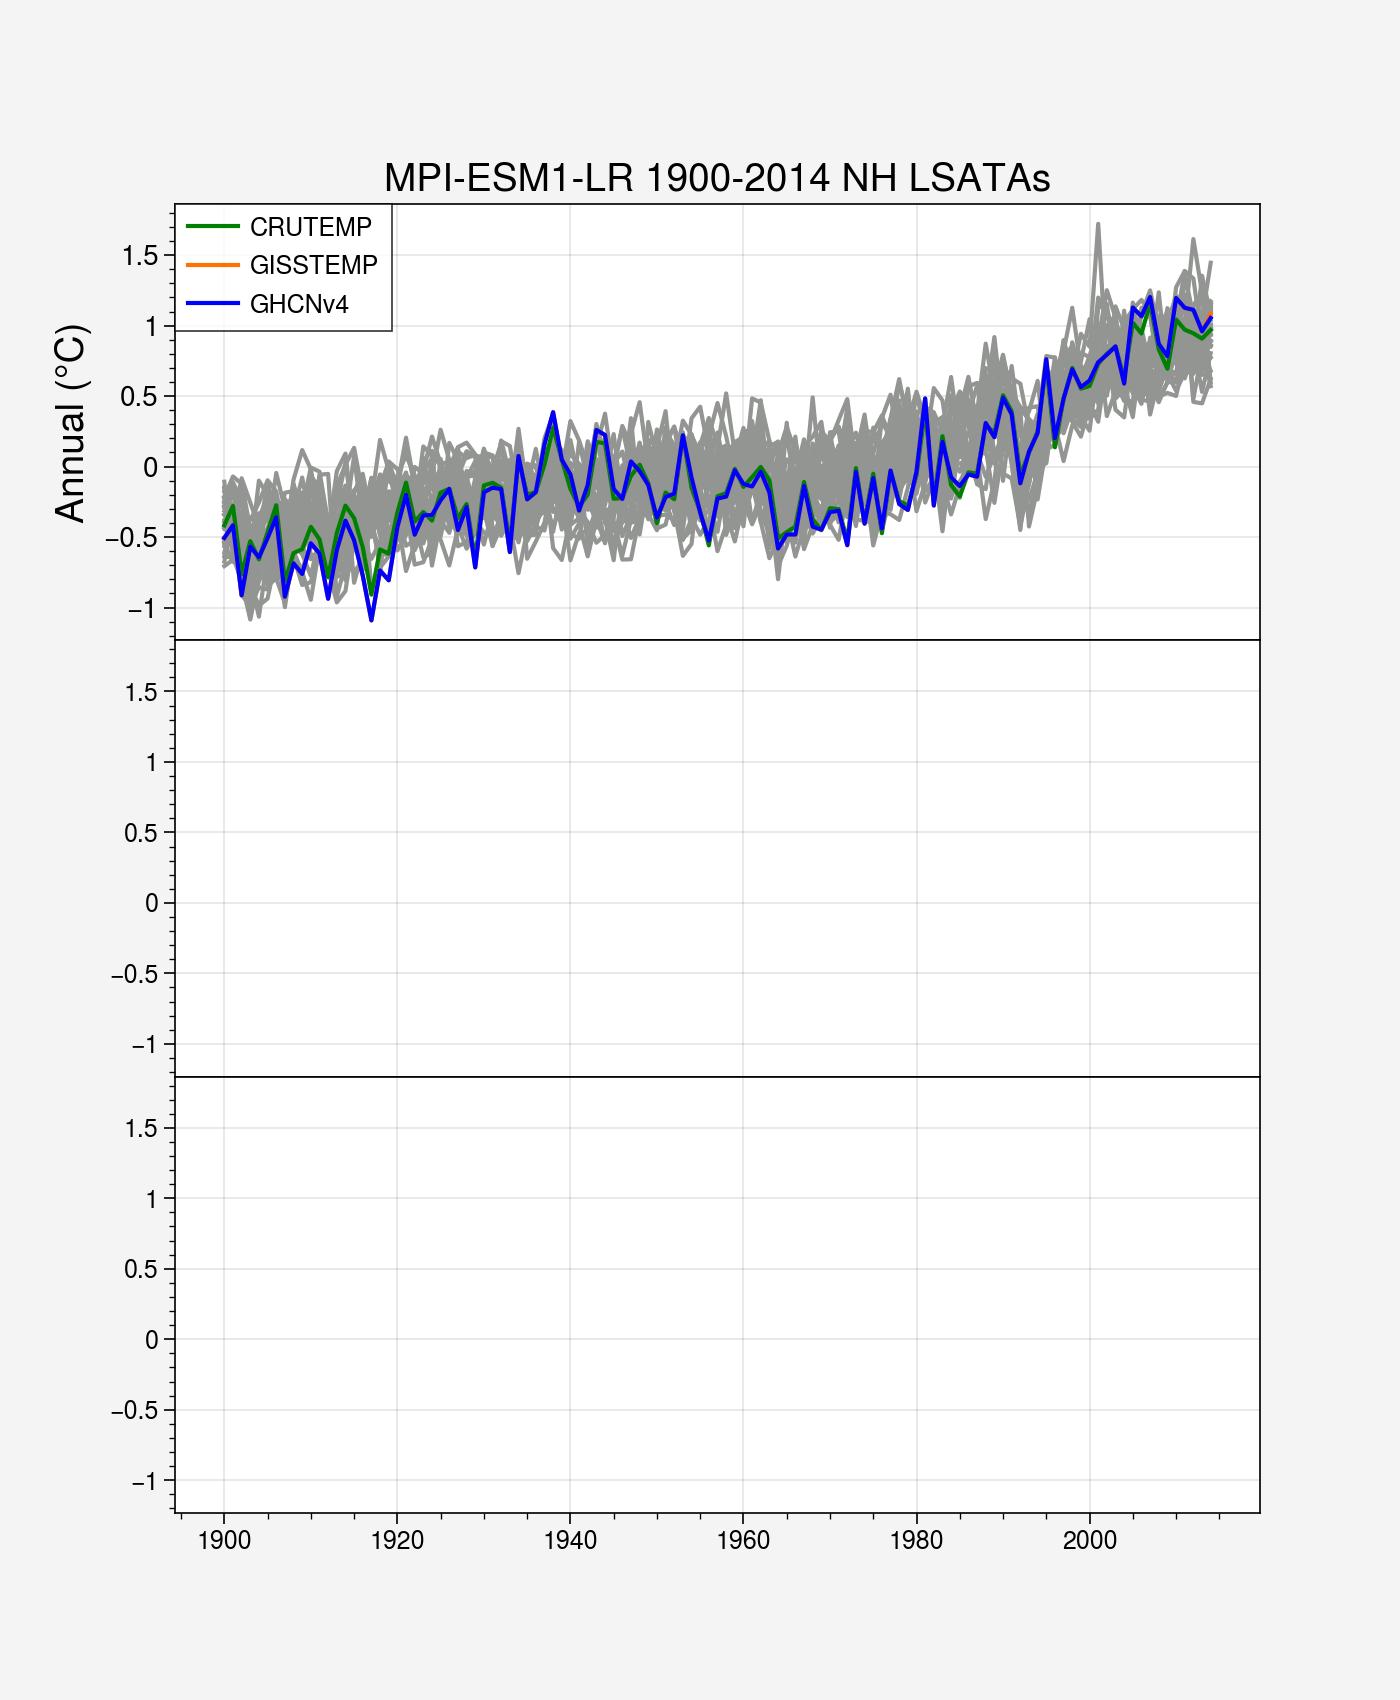

In [23]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

for i in range(num_time_series):
    axs[0].plot(x, tas_ano_annual[i, :], color='gray')
    
axs[0].plot(x, CRUTEMP_annual, color='green', label='CRUTEMP')
axs[0].plot(x, GISSTEMP_annual, color='orange', label='GISSTEMP')
axs[0].plot(x, GHCNTEMP_annual, color='blue', label='GHCNv4')
axs[0].set_title('MPI-ESM1-LR 1900-2014 NH LSATAs',fontsize=14)
axs[0].set_ylabel('Annual (°C)', fontsize=14)
axs[0].set_xlabel('Time/year', fontsize=14)
# axs[0].grid(visible=False, which='major', axis='y')
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

handles, labels = axs[0].get_legend_handles_labels()
legend = axs[0].legend(handles, labels, loc='best')
for text, handle in zip(legend.get_texts(), legend.legendHandles):
    color=handel.get_color()
    text.set_color(color)

# axs[0].legend()
# Plot the JJA time series
for i in range(num_time_series):
    axs[1].plot(x, JJA_tas_mean[i, :], label=f"Time Series {i+1}", color='gray')

axs[1].plot(x, CRUTEMP_JJA, color='green')
axs[1].plot(x, GISSTEMP_JJA, color='orange')
axs[1].plot(x, GHCNTEMP_JJA, color='blue')
axs[1].set_ylabel('JJA (°C)', fontsize=14)
axs[1].set_xlabel('Time/year', fontsize=14)
# axs[1].grid(visible=False, which='major', axis='y')
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

# Plot the DJF time series
for i in range(num_time_series):
    axs[2].plot(x, DJF_tas_mean[i, :], label=f"Time Series {i+1}", color='gray')
    
axs[2].plot(x, CRUTEMP_DJF, color='green')
axs[2].plot(x, GISSTEMP_DJF, color='orange')
axs[2].plot(x, GHCNTEMP_DJF, color='blue')
# axs[2].set_title('MPI-ESM1-LR 1850-2014 DJF SAT')
axs[2].set_ylabel('DJF(°C)', fontsize=14)
axs[2].set_xlabel('Time/year', fontsize=14)
# axs[2].grid(visible=False, which='major', axis='y')
axs[2].tick_params(axis='x', labelsize=10)
axs[2].tick_params(axis='y', labelsize=10)

plt.show()

In [ ]:
fig.savefig("MPI-ESM-LR-NH_averaged_SAT_TS_1850-2014.png")

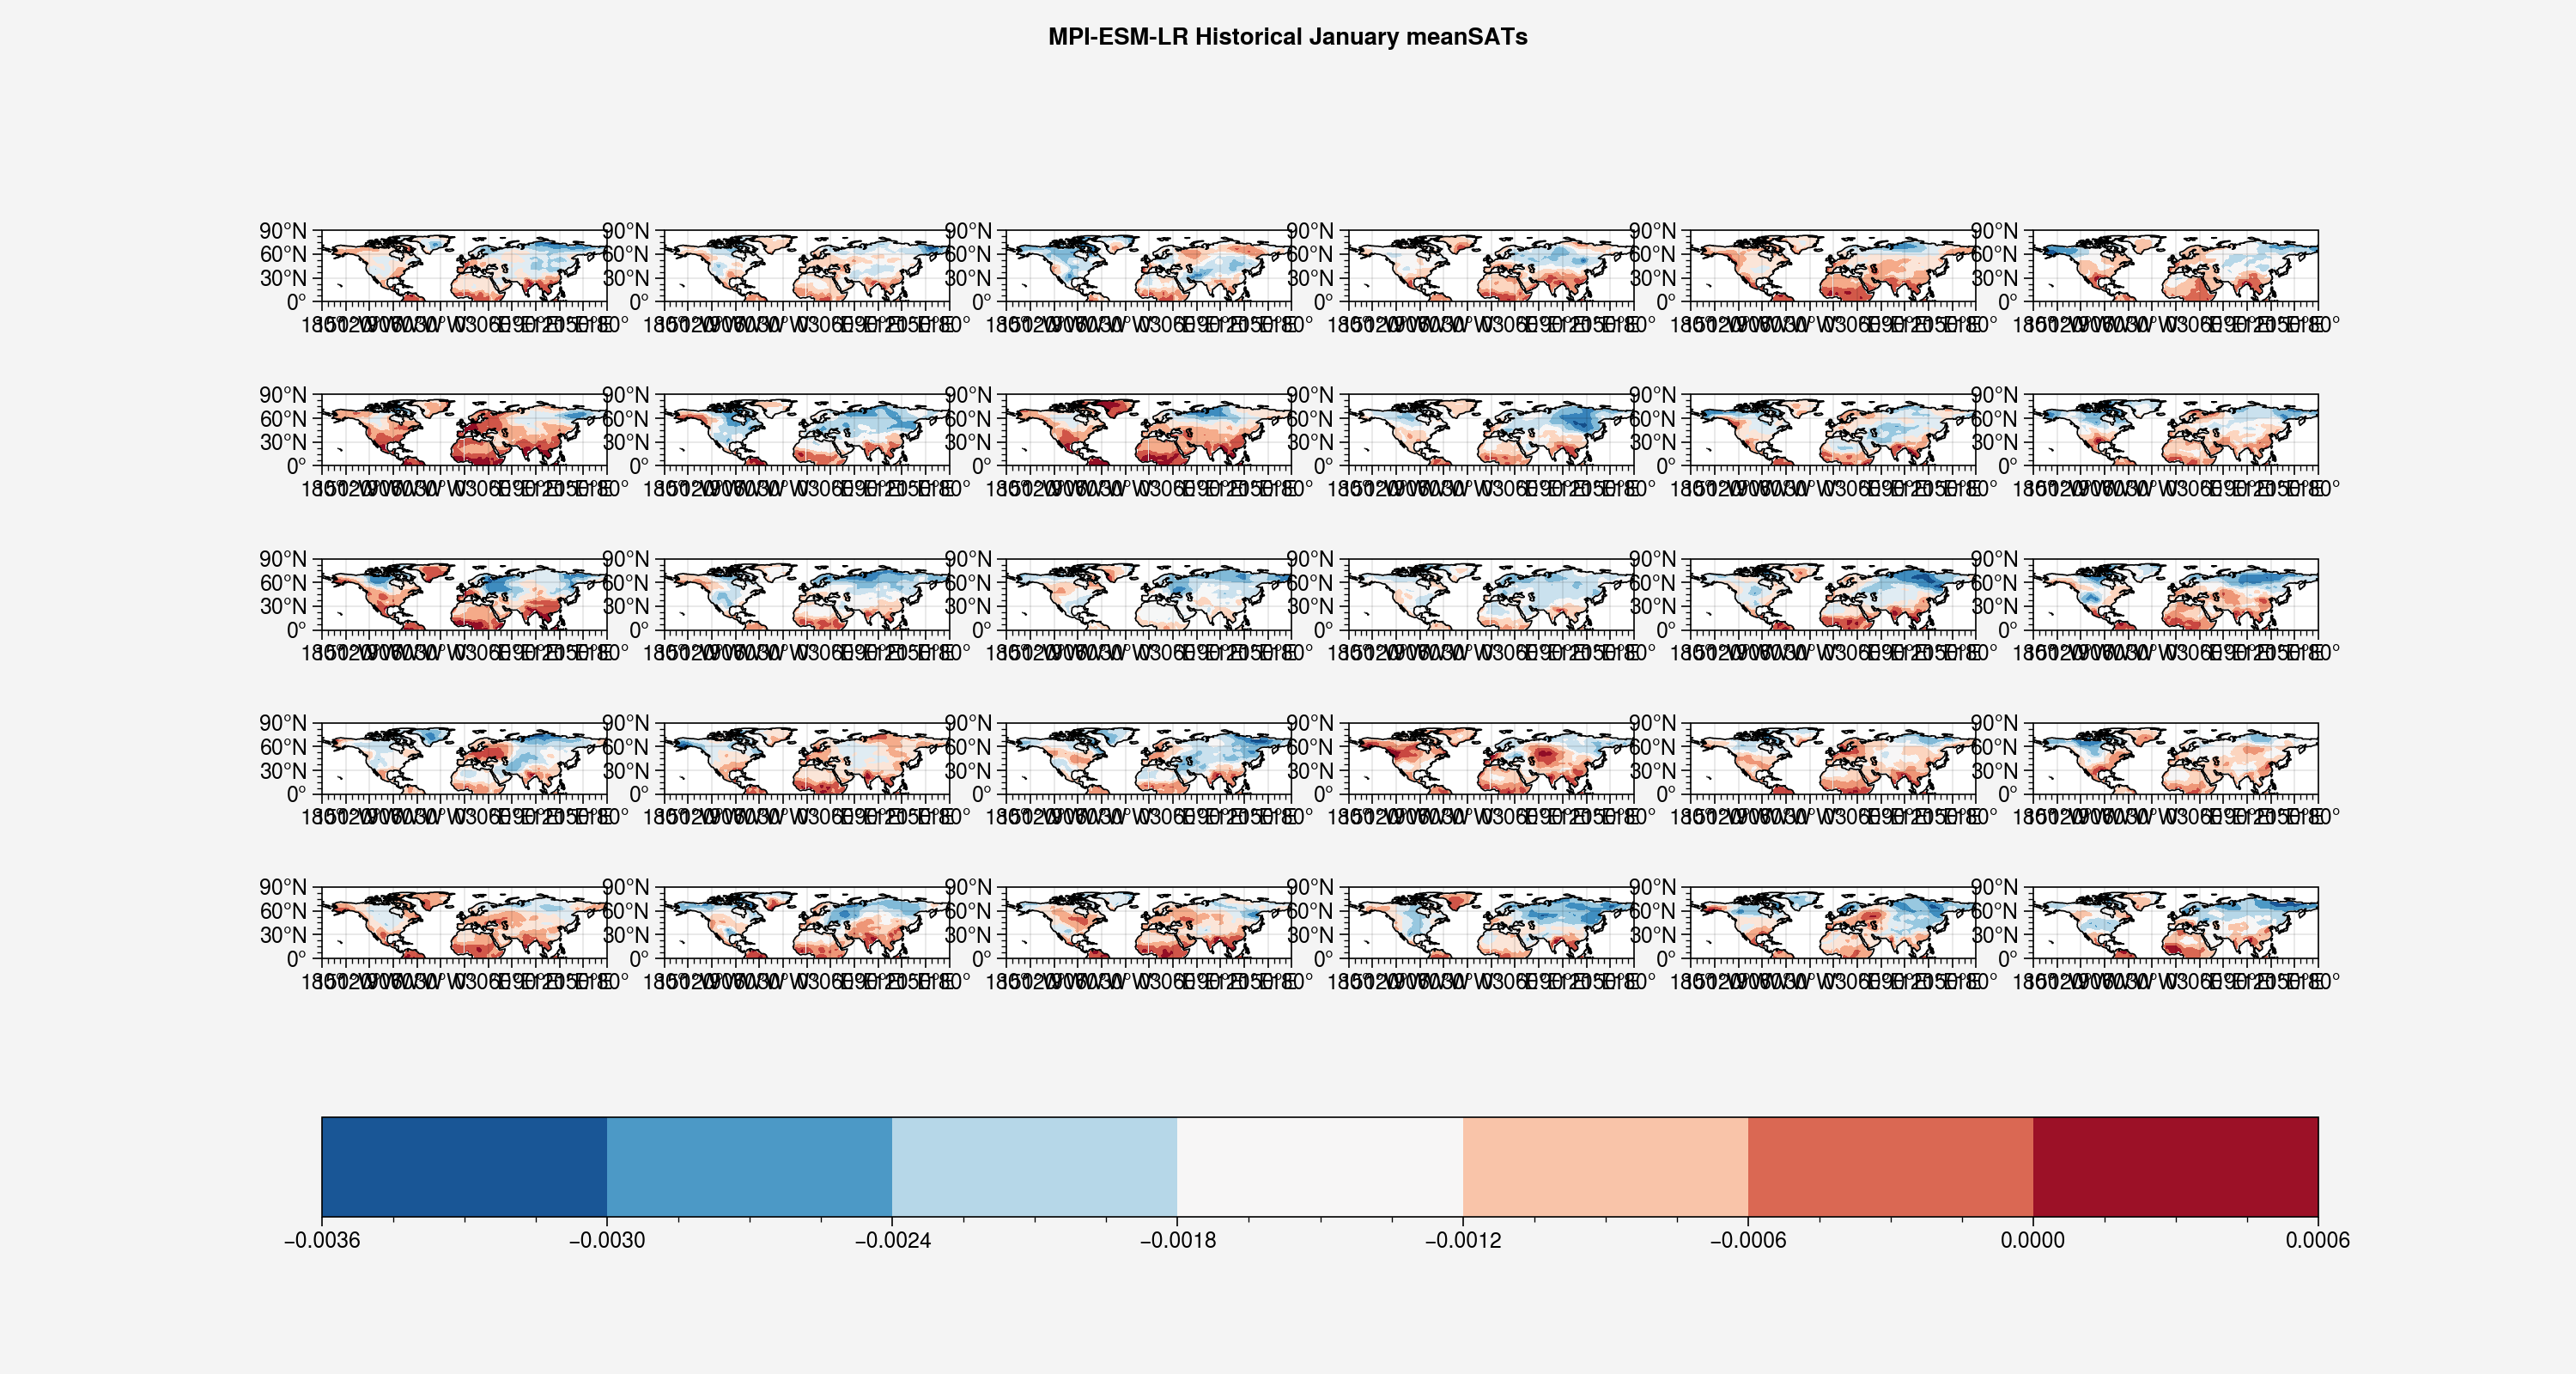

In [57]:

# import proplot as pplt
rows = 5
cols = 6

# create the figure and axes
projection = ccrs.PlateCarree()
fig, axs = plt.subplots(rows, cols, figsize=(15,8), subplot_kw={'projection':projection})
fig.suptitle('MPI-ESM-LR Historical January meanSATs')

# plot each model run
for i,ax in enumerate(axs.flat):
    mp=ax.contourf(lon, lat, annual_mean_anomalies[i, :, :], cmap='RdBu_r')#levels=np.arange(-30,30, 2.5)
    ax.set_xticks(np.arange(-180, 210, 30))#, crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 120, 30))#, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.coastlines()
fig.colorbar(mp, ax=axs, orientation='horizontal', fraction=.1)
    
# add a legend and axis labels
# ax.legend()
# ax.set_xlabel('Time')
# ax.set_ylabel('Model Output')
# display the figure
plt.show()
# images = []
# for i in range(Nr):
#     for j in range(Nc):
#         # Generate data with a range that varies from one plot to the next.
#         data = tas_ano()
#         images.append(axs[i, j].imshow(data))
#         axs[i, j].label_outer()

# # Find the min and max of all colors for use in setting the color scale.
# vmin = min(image.get_array().min() for image in images)
# vmax = max(image.get_array().max() for image in images)
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for im in images:
#     im.set_norm(norm)